<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
GLM - Drop1 decrease in predictive performance
</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

This notebook defines and calculates the explainability statistics "drop1 decrease in predictive performance" for the GLM. 

## Issues with GLM coefficients

GLMs are sometimes denoted as being "inherently explainable". This is often just stated as a fact without providing further details, but is most likely due to two properties of GLM-models:

* All features the model uses are known, since they have to be constructed explicitly by the modeller.
* The impact of feature values on model values is evident from the linear structure of the model: model values are just feature values multiplied by constant coefficients.

The two facts above, may suggest that all relevant explanations, in particular the importance of the input variables, can be (easily?) derived from the coefficients of the linear model. This report argues that this is not true in general but requires additional assumptions which are not met in the use case for the GLTD recovery rates. As a consequence, the report suggests a different approach to measure reliably variable importance for this use case.
The idea to use the size of coefficients as a measure of variable importance stems from the impression that these coefficients, after suitable normalization, represent marginal effects, which is often described as "the change of the independent variable after a one unit change of the dependent variable while all other variables remain fixed."

Obviously, this assumes tacitly a main-effects-only model, since it is impossible to vary, say, $X_1$ while the features $X_1^2$ or $X_1 X_2$ remain unchanged. Furthermore, this is only true for main effects models with either identity link function or for explanations on the linear instead of the transformed scale. Recall that in our case of logistic regression the variable of interest, the recovery probability $\pi,$ is linked to the linear predictor $X\beta$ by the logit, i.e.

$$ \text{logit}(\pi(\beta)) = X\beta $$
or 
$$ \pi(\beta)= \frac{\exp X\beta}{1 + \exp X\beta}$$

and the change of $\pi$, with respect to input $i$, i.e. the derivative $\frac{\partial \pi}{\partial X_i}$, is given by
$$ \frac{\partial \pi}{\partial X_i}= \beta_i \frac{\exp X\beta}{(1 + \exp X\beta)^2.}$$ 
In contrast to the linear model with identity link, here the change does not depend only on $\beta_i$ but on the values of all other coefficients and input values.
Further complications arise from the use of categorical variables. One-Hot encoding creates dependent variables, where typically one level is dropped. But this means the coefficient of the dropped level is always zero, by definition, no matter the properties of the subgroup of the data with this level. In addition, the dropped level is completely arbitrary, which means that values of coefficients are dependent on the completely arbitrary coding scheme employed. This is also true for  coding schemes different from one-hot encoding, such as sum or orthogonal contrasts.
One may propose as possible solution, to not drop levels after one hot encoding and resolve the singularity of the design matrix by regularization. But this solves only the technical problem, it does not solve the underlying conceptional issue. One hot encoded indicators are not independent, it is logically impossible, to vary one of those indicators while not changing the others. Of course, this is not only a challenge for variable importance by size of coefficient. Any variable importance method, which assigns importance scores to indicators of levels of a categorical variable, must address and solve this.  
Finally, coefficients of levels are unrelated to the prevalence of the level in the data. Arguably, a large coefficient, which only applies to a tiny subgroup of the data, is less important, than the coefficient for a level applicable to the majority of the data. For continuous inputs this is to a certain addressed by normalization. But there seems to be no consensus, if and how categorical levels should be normalized to take size differences within a category into account.
   
As a consequence of the issues and observations above, the size of the coefficients is not pursued further as means to assign variable importance. But note that this conclusion is not shared by all machine learning frameworks.

H2O states: "[GLM/GAM: Variable importance represents the coefficient magnitudes.](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html#glm-gam)"  Caret does something even more unusual. The description of the function `varImp` states: "[Linear Models: the absolute value of the t-statistic for each model parameter is used.](https://topepo.github.io/caret/variable-importance.html#model-specific-metrics)" Scikit-learn does discuss the [interpretation of coefficients](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html) thoroughly but does not suggest their size as indication of importance.

Further discussion and examples on the connection between coefficients and variable importance in least squares models with identity link case and continuous inputs can be found in the report "report_scr_maineff.html".

## Drop 1 decrease in predictive power

Drop1 is a simple and straightforward approach to variable importance. The importance of a variable is defined as the decrease in predictive power if this variable is dropped from the set of available inputs. Predictive power is measured, as always, by the loss on a test set. 

The method is implemented in the code below as follows:
1. Fix a train and test set.
2. Fit the base model on the train set and record its loss on the test set.
3. Loop through all available input variables:
    1. Call the current input variable `curval`
    2. Fit the model on the train set using all inputs except `curval`. Record the loss on the test set of this model.
4. Calculate the difference (i.e. increase) in loss between the base model and each model with an input dropped.
5. Output the list of variables sorted by the difference.

The most important, i.e. the highest ranked, variable will be that variable which has the worst, i.e. largest, loss. The full model, called below "none" because no variable has been dropped, will always have the lowest loss, i.e. it should be ranked at the bottom. Up to sampling error, of course.

The ranking suffers from substantial sampling error, even for large samples. To show this, the algorithm above will be run a number of times on bootstrapped train/test sets so that the respective rankings can be compared.  

## Properties

Variable importance by decrease in predictive power has some appealing properties:
* Straightforward to explain, even to non-experts.
* Direct and obvious connection between variable importance and the purpose of the model.
* Completely model agnostic.
* Works in the same way for all loss functions
* Works in the same way for all input types, i.e. numerical, categorical, no matter what the encoding.
* Does not suffer from the impossible data problem.  
* Easy to implement.

Sadly, it comes also with some disadvantages:
* Each model has to be refitted. Depending on the type of model, this iterative refitting may be more efficient, since some information (such as the design matrix) can be shared. But in general, the computational demands are of the order of $d*M$, where $d$ is the number of inputs and $M$ the effort to fit the base model. 
* Decrease in predictive power does not explain the original full model, it explains the importance of a variable in the modelling process.
* It suffers from the dependence issue. For example, if the inputs contain two variables with very similar information content, each variable is assigned low importance, since the presence of only one of the two variables suffices to make predictions. Only when the two are dropped jointly, their importance will become visible.

The dependence problem could be fixed by Shapley attribution (see the notebook "report_scr_interaction"). But this does not work here due to computational resource limitations. 

# Initialisation

In [1]:
from glum import GeneralizedLinearRegressor
from scipy.stats import rankdata

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt

# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 

import os
import pickle

import gltd_utilities

import warnings
import time
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

To run the notebook:

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somehwat volatile.

In [2]:
tic = time.time()
path_to_data = "./"
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            path_to_data, pct=0.3)
seed

'170300352323865877625718136349231958513'

In [12]:
# file for cached bootstrap
cachefile = path_to_data + "cache_drop1_GLM.pkl"

## GLM definition

In [3]:
# function for all model definitions
def fun_md(fitvars):

    fml = "~ " + "+".join(fitvars)

    return(GeneralizedLinearRegressor(
    l1_ratio=0.0,
    alpha=1e-6,
    family="binomial", 
    link="logit",
    fit_intercept=True,
    drop_first=True,
    formula = fml
    ))

## Drop1 loop

This block implements the algorithm described above. The expression ``GroupShuffleSplit`` parameterize the train/test split and the number of bootstrap repetitions. If you do not want to use the cached data, a first very quick run could use, e.g. n_split=2 and train_size=0.1, test_size=0.03.

In [4]:
# Check for cache
if os.path.exists(cachefile):
    with open(cachefile, 'rb') as f:
        cachedata = pickle.load(f)
    
    typelist = cachedata["typelist"]
    lltrainlist = cachedata["lltrainlist"]
    lltestlist = cachedata["lltestlist"]
    nsplit = cachedata["nsplit"]
    allvars = cachedata["allvars"]

else:
    # Input variables to use
    allvars = nm_cat + nm_num

    gss = GroupShuffleSplit(n_splits=30, train_size=0.7,
                            random_state=rng.integers(low=0, high=1000))
    nsplit = gss.get_n_splits()
    
    # container for results
    typelist = list()
    lltrainlist = list()
    lltestlist = list()

    for ii, (trainidx, testidx) in enumerate(gss.split(X, groups= ID)):
        print("--------------------------------------------")
        print(f"Run {ii + 1}:")
        print("--------------------------------------------")

        xtrain, xtest = X.iloc[trainidx, :], X.iloc[testidx, :]
        ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]

        # Fit full model
        md = fun_md(allvars)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            md.fit(xtrain, ytrain)
        
        # performance statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            phat = {"train": md.predict(xtrain), "test": md.predict(xtest)}

        typelist = typelist + ["none"]
        lltrainlist = (lltrainlist 
                    + [log_loss(ytrain, phat["train"])])
        lltestlist = (lltestlist 
                    + [log_loss(ytest, phat["test"])])
        
        # Loop over all drop1 models
        for dropvar in allvars:
            # print(dropvar)
            
            curvars = set(allvars) - {dropvar}
            md = fun_md(list(curvars))

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                md.fit(xtrain.drop(dropvar, axis=1), ytrain)

            # performance statistics
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                phat = {"train": md.predict(xtrain), "test": md.predict(xtest)}

            typelist = typelist + [dropvar]
            lltrainlist = (lltrainlist 
                    + [log_loss(ytrain, phat["train"])])
            lltestlist = (lltestlist 
                    + [log_loss(ytest, phat["test"])])

    # write results of bootstrap to disk
    cachedata = {"typelist": typelist, "lltrainlist": lltrainlist,
                "lltestlist": lltestlist, 
                "nsplit": nsplit,
                "allvars": allvars}

    with open(cachefile, 'wb') as f:
            pickle.dump(cachedata, f)

--------------------------------------------
Run 1:
--------------------------------------------
--------------------------------------------
Run 2:
--------------------------------------------
--------------------------------------------
Run 3:
--------------------------------------------
--------------------------------------------
Run 4:
--------------------------------------------
--------------------------------------------
Run 5:
--------------------------------------------
--------------------------------------------
Run 6:
--------------------------------------------
--------------------------------------------
Run 7:
--------------------------------------------
--------------------------------------------
Run 8:
--------------------------------------------
--------------------------------------------
Run 9:
--------------------------------------------
--------------------------------------------
Run 10:
--------------------------------------------
-----------------------------

## Analysis

In [5]:
# remember: row-major!
lltrainarr = 100**2 * np.array(lltrainlist).reshape(nsplit, 1 + len(allvars))
lltestarr = 100**2 * np.array(lltestlist).reshape(nsplit, 1 + len(allvars))
decpp_train = lltrainarr - lltrainarr[:,0].reshape(-1,1)
decpp_test = lltestarr - lltestarr[:,0].reshape(-1,1)

resdf = pd.DataFrame({
    "decpp train": np.round(np.mean(decpp_train, axis=0),1),
    "decpp test": np.round(np.mean(decpp_test, axis=0),1)},
    index=typelist[:(1 + len(allvars))]
)
resdf.index.name = "dropped"
resdf.sort_values(["decpp test"], ascending=False)

,decpp train,decpp test
dropped,,
Original_Social_Security_Award_Status,32.9,32.8
OwnOccToAnyTransition,17.0,16.9
Diagnosis_Category,6.8,6.7
Updated_Social_Security_Award_Status,4.4,4.5
Elimination_Period,1.9,1.8
Duration_Month,1.3,1.3
Integration_with_STD,0.5,0.5
Benefit_Max_Limit_Proxy,0.5,0.5
Indexed_Monthly_Salary,0.0,0.4


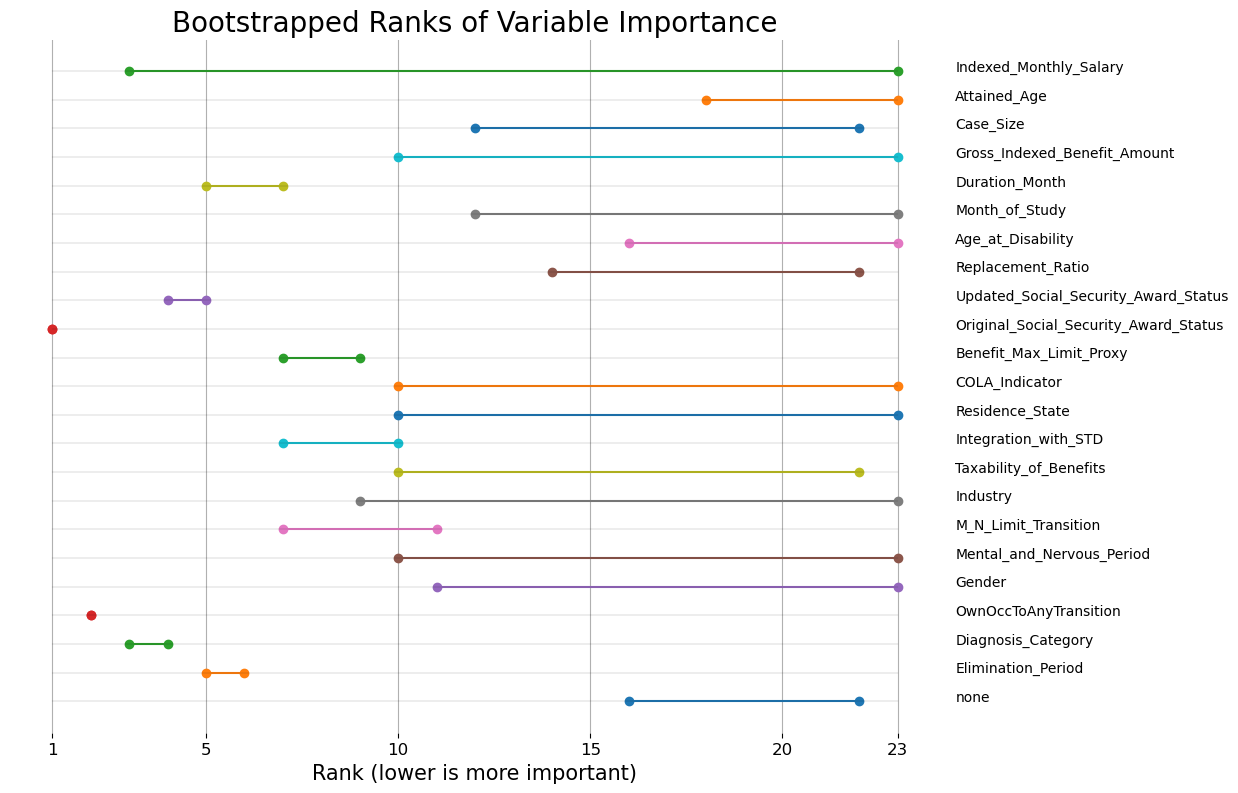

In [11]:
vi = 2 + len(allvars) - np.apply_along_axis(rankdata, 1, lltestarr)
hilist = np.max(vi, axis=0)
lolist = np.min(vi, axis=0)
lims = [(lo, hi) for lo, hi in zip(lolist, hilist)]
fig, ax = plt.subplots(figsize = (12,9))
tmp = len(lims) - 1
for i, (start, end) in enumerate(lims):
    ax.plot([start, end],  [i, i], marker='o')
    ax.plot([1, tmp+1],  [i, i], color="black", lw=0.1)
    ax.text(tmp + 2.5, i, typelist[i])
ax.set_yticks([])
ax.set_xticks([1,5,10,15,20,len(allvars) + 1])
ax.grid(which="major", axis="x")
ax.set_xlabel("Rank (lower is more important)")
# Remove bounding box (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
dummy = ax.set_title("Bootstrapped Ranks of Variable Importance")

## Interpretation

The exhibit above provides evidence for the split of importance into two, maybe three groups:
* The top variables, which are clearly important (ranks 5 and up). They are not only consistently ranked in the top group, but their relative position within this group are fixed. Those variables are
  1. Original_Social_Security_Award_Status
  2. OwnOccToAnyTransition
  3. Diagnosis_Category
  4. Updated_Social_Security_Award_Status
  5. Duration_Month
  6. Elimination_Period. 
* For all other inputs importance fluctuates wildly over a wide range. Ranks in this group seem to be mainly noise. For example, the entry "none" is the full model. Without sampling error, this entry should always be ranked 1 or last, as this is the run with all variables present or no variable dropped. This divergence is remarkable, given the very large sample size (test data is roughly 600K observations).

In [7]:
print(f"Time it took: {np.ceil((time.time() - tic)/60)}min.")

Time it took: 87.0min.
